In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mat73
from scipy.interpolate import griddata

from smoothen_surface import smoothen

%matplotlib notebook

In [2]:
# Read data
data = mat73.loadmat("SKULL-MAPS/skull_mask_bm7_dx_0.125mm.mat")

xi = data["xi"]
yi = data["yi"]
zi = data["zi"]

skull_mask = data["skull_mask"]
brain_mask = data["brain_mask"]

In [3]:
# Get skull points
X, Y, Z = np.meshgrid(xi, yi, zi, indexing="ij")

x_skull = X[skull_mask]
y_skull = Y[skull_mask]
z_skull = Z[skull_mask]

In [4]:
# Create a dataframe
p_skull_volume = np.hstack((x_skull[:, np.newaxis],
                            y_skull[:, np.newaxis],
                            z_skull[:, np.newaxis]))
skull_volume_df = pd.DataFrame(p_skull_volume, columns=["X", "Y", "Z"])

In [5]:
# Get minimum and maximum at each (Y, Z) points
skull_surface_inner_df = skull_volume_df.groupby(["Y", "Z"]).max().reset_index()
skull_surface_outer_df = skull_volume_df.groupby(["Y", "Z"]).min().reset_index()

# Rearrange columns
skull_surface_inner_df = skull_surface_inner_df[["X", "Y", "Z"]]
skull_surface_outer_df = skull_surface_outer_df[["X", "Y", "Z"]]

# Sort based on Y and Z columns
skull_surface_inner_df = skull_surface_inner_df.sort_values(by=["Y", "Z"])
skull_surface_outer_df = skull_surface_outer_df.sort_values(by=["Y", "Z"])

In [6]:
# Convert to numpy array
skull_surface_inner = skull_surface_inner_df.to_numpy()
skull_surface_outer = skull_surface_outer_df.to_numpy()

In [7]:
X = skull_surface_outer[:, 0].reshape(yi.shape[0], zi.shape[0])
Y = skull_surface_outer[:, 1].reshape(yi.shape[0], zi.shape[0])
Z = skull_surface_outer[:, 2].reshape(yi.shape[0], zi.shape[0])

In [8]:
X

array([[46.   , 46.   , 45.875, ..., 44.875, 44.875, 44.875],
       [45.875, 45.875, 45.875, ..., 44.75 , 44.75 , 44.875],
       [45.875, 45.875, 45.75 , ..., 44.625, 44.75 , 44.75 ],
       ...,
       [42.25 , 42.25 , 42.125, ..., 41.25 , 41.25 , 41.375],
       [42.25 , 42.25 , 42.125, ..., 41.25 , 41.375, 41.375],
       [42.375, 42.25 , 42.25 , ..., 41.375, 41.375, 41.5  ]])

<IPython.core.display.Javascript object>


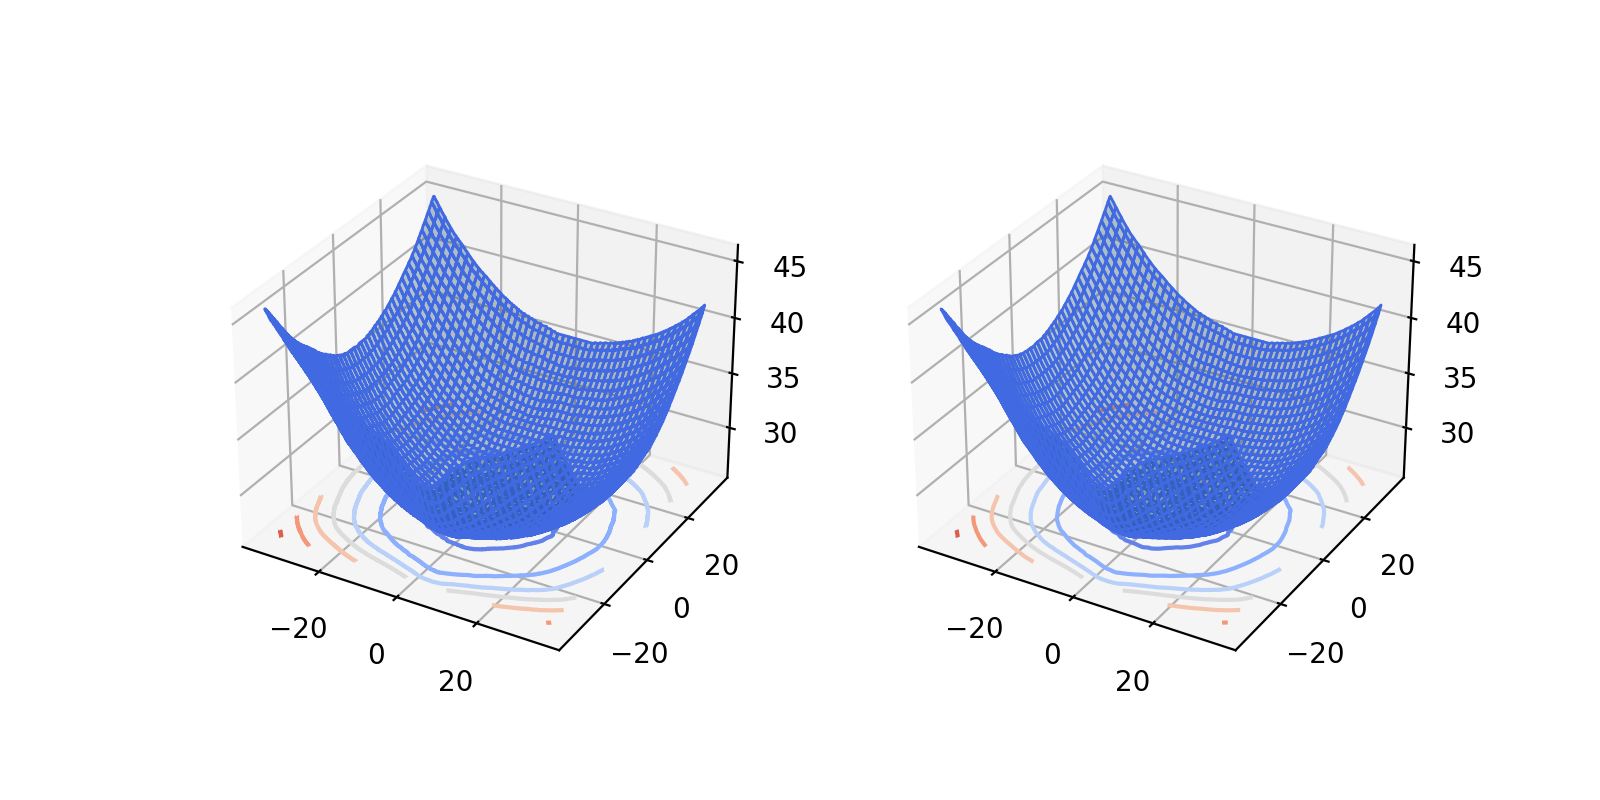

In [9]:
# Before smoothing
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121, projection="3d")

ax1.plot_surface(Y, Z, X, edgecolor='royalblue', alpha=0.3)
ax1.contour(Y, Z, X, zdir='z', offset=26, cmap='coolwarm')

# After smoothing
X_smooth = smoothen(X, 2)

ax2 = fig.add_subplot(122, projection="3d")

ax2.plot_surface(Y, Z, X_smooth, edgecolor='royalblue', alpha=0.3)
ax2.contour(Y, Z, X_smooth, zdir='z', offset=26, cmap='coolwarm')

In [10]:
# Print maximum before and after smoothing
print(X.min(), X_smooth.min())

25.75 25.75001575332926


In [22]:
# Interpolate on smaller mesh size
points_y, points_z = np.mgrid[-35:35:71j, -35:35:71j]
Points = np.hstack((Y.reshape(-1, 1), Z.reshape(-1, 1)))

interp_x_0 = griddata(Points, X.flatten(), (points_y, points_z), method='linear')
interp_x_1 = griddata(Points, X.flatten(), (points_y, points_z), method='nearest')
interp_x_2 = griddata(Points, X.flatten(), (points_y, points_z), method='cubic')

In [23]:
# Print maximum before and after interpolation
print(X.min(), X_smooth.min(), interp_x_0.min(), interp_x_1.min(), interp_x_2.min())

25.75 25.75001575332926 25.75 25.75 25.75


In [26]:
interp_x_0

array([[46.   , 45.625, 45.125, ..., 44.125, 44.5  , 44.875],
       [45.375, 45.125, 44.625, ..., 43.5  , 43.875, 44.375],
       [45.   , 44.625, 44.125, ..., 43.   , 43.375, 43.75 ],
       ...,
       [41.75 , 41.25 , 40.75 , ..., 39.625, 40.125, 40.625],
       [42.   , 41.5  , 41.   , ..., 40.125, 40.5  , 41.   ],
       [42.375, 41.875, 41.375, ..., 40.5  , 41.   , 41.5  ]])

In [24]:
# Differences between the 3 methods

print(np.linalg.norm(interp_x_0-interp_x_2))

0.0


<IPython.core.display.Javascript object>


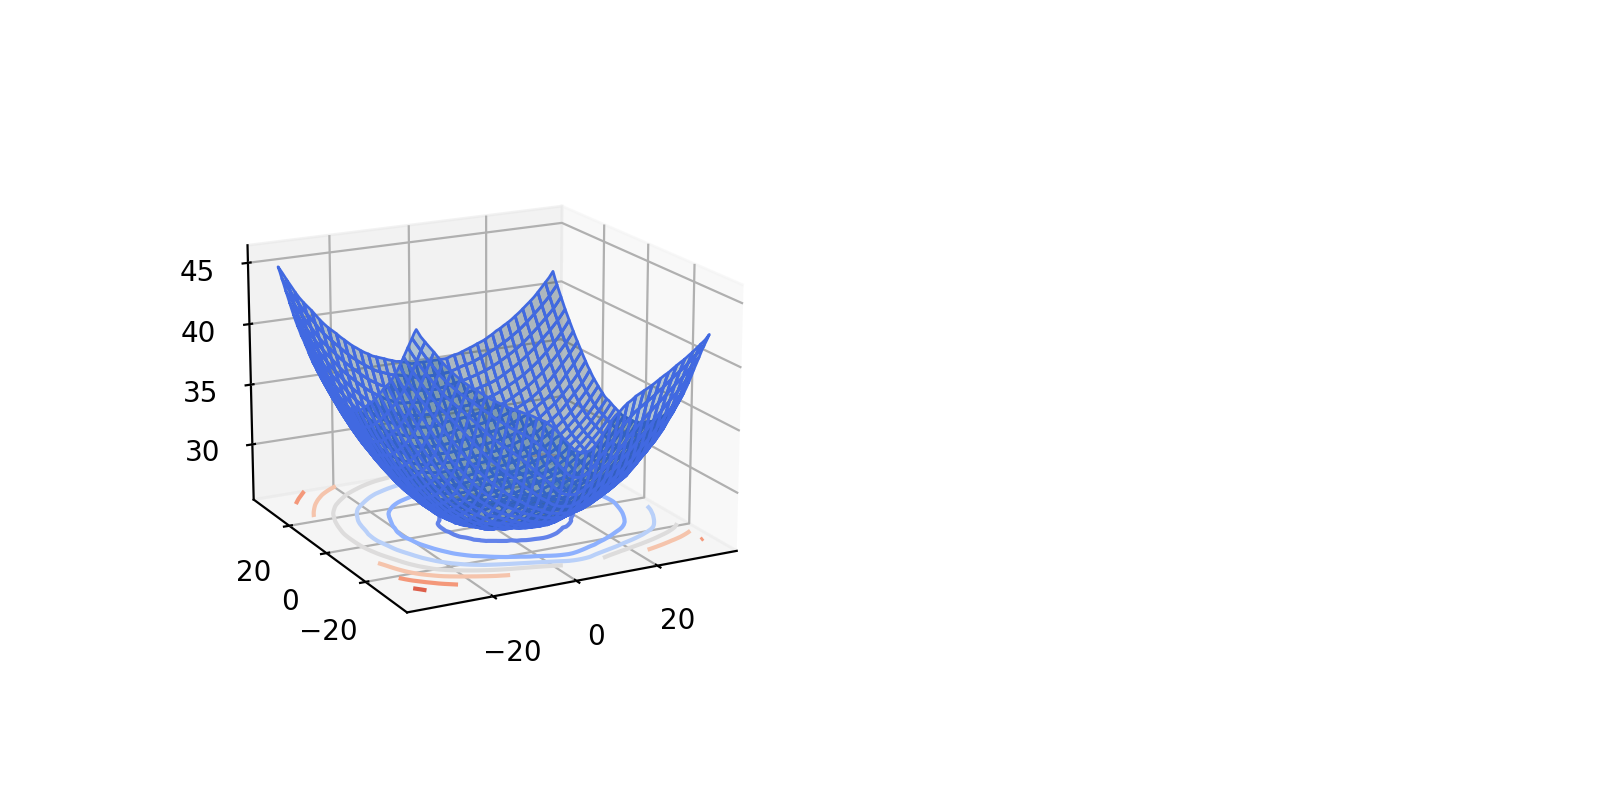

In [25]:
# Before smoothing
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121, projection="3d")

ax1.plot_surface(points_y, points_z, interp_x, edgecolor='royalblue', alpha=0.3)
ax1.contour(points_y, points_z, interp_x, zdir='z', offset=26, cmap='coolwarm')